# Fine-Tuning - Testing the model

In this notebook, we test two models trained with Fine-Tuning. The code with the train process can be found here.

Fine tuning is another kind of transfer learning. The process is composed by two step, the first of them is similar to the feature extraction. We define the top of the network to take care about the classification, while the body of the network uses the weights from the pre-trained model to extract features. In this step, the top (or head) of the network does not have access to the body of the network (the base model is not trainable). The top of the network tweaks the weights by itself.

The second step is the fine tuning. In this moment the top of the network communicates with the body (partially or completely), tweaking the weights with the pre-trained model. We consider two models trained with the fine tuning on 17 Flowers dataset.

## Importing Libraries

In [1]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from compvis.preprocessing import ImageToArrayPreprocessor
from compvis.preprocessing import ResizeAR
from compvis.datasets import SimpleDatasetLoader
from tensorflow.keras.models import load_model
from tensorflow.keras.models import save_model
from imutils import paths
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt

## Setting the dataset

In [2]:
dataset = "/home/igor/Documents/Artificial_Inteligence/Datasets/17flowers" # the path for the dataset

**Making the list of images path**

In [3]:
imagesPath = list(paths.list_images(dataset))

**Getting the list of class names**

In [4]:
classNames = [pt.split(os.path.sep)[-2] for pt in imagesPath]
classNames = [str(x) for x in np.unique(classNames)]

### Loading and preprocessing the images

In [5]:
ar = ResizeAR(224, 224)
iap = ImageToArrayPreprocessor()

In [6]:
dl = SimpleDatasetLoader([ar, iap])
data, labels = dl.load(imagesPath, 500)
data = data.astype("float") / 255.

[INFO] processed 500/1360
[INFO] processed 1000/1360


### Splitting the dataset into training and test set

In [7]:
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [8]:
le = LabelBinarizer()

In [9]:
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

## Loading the models

In this moment, we load the model before and after the fine-tuning. We present the curves of the loss function and accuracy. We realize the predictions on the test set evaluating them with the classification report.

**Without fine-tuning**

In [10]:
model = load_model("hdf5/no_fine_tuning.hdf5") # loading model from disk

In [11]:
model.summary() # print the model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

**About fine-tuning**

As we can observer, the model has a certain number of trainable parameters. These parameter come from the Head of the network (flatten, dense, dropout and dense_1). All layers above the flatten layer work as feature extractor. The layers on the body do not tweak the weights, just the Head of the network. 

    for layer in baseModel.layers:

        layer.trainable = False

The model will be trained with 25 epochs. After the train, we consider

    for layer in baseModel.layers[15:]:

        layer.trainable = True

The model will be trained from block5_conv1 (Conv2D) to the end. In this moment the weights from the pre-trained model will be changed from block5_conv1 (Conv2D). The total of trainable parameters is higher.


**Predictions and evaluations**

In [12]:
predictions = model.predict(X_test, batch_size=32)
model.evaluate(X_test, y_test, batch_size=32)

340/340 [==============================] - 2s 6ms/sample - loss: 0.5756 - accuracy: 0.8353


[0.5755922371850294, 0.8352941]

In [13]:
cr = classification_report(y_test.argmax(axis = 1), predictions.argmax(axis=1))

In [14]:
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.65      0.79        20
           1       0.64      0.90      0.75        20
           2       0.94      0.94      0.94        18
           3       0.92      0.75      0.83        16
           4       0.93      0.93      0.93        27
           5       0.56      1.00      0.71        20
           6       0.74      0.94      0.83        18
           7       0.83      0.83      0.83        23
           8       1.00      0.79      0.88        19
           9       1.00      0.68      0.81        22
          10       0.83      0.67      0.74        15
          11       1.00      0.50      0.67        16
          12       1.00      0.95      0.97        19
          13       1.00      0.91      0.95        23
          14       0.57      0.76      0.65        21
          15       0.90      0.95      0.93        20
          16       1.00      0.91      0.95        23

    accuracy              

**Visualizing the metrics from the train process**

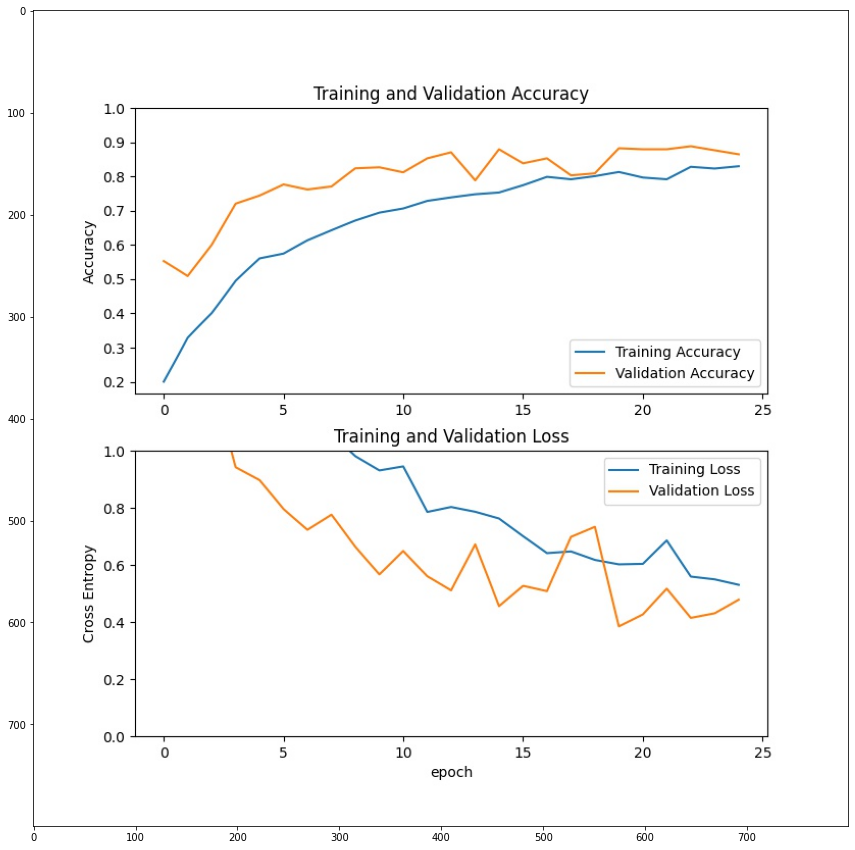

In [15]:
import cv2
plt.figure(figsize=(15,15))
img = cv2.imread("output/no_fine_tuning.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

**Fine tuning**

In [16]:
model_f = load_model("hdf5/fine_tuning.hdf5") # loading model from disk

In [17]:
model_f.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

**Predictions and evaluations**

In [18]:
predictions = model_f.predict(X_test, batch_size=32)
model_f.evaluate(X_test, y_test, batch_size=32)

340/340 [==============================] - 2s 7ms/sample - loss: 0.2851 - accuracy: 0.9382


[0.28511925986694064, 0.9382353]

In [19]:
cr = classification_report(y_test.argmax(axis = 1), predictions.argmax(axis=1))

In [20]:
print(cr)

              precision    recall  f1-score   support

           0       0.94      0.75      0.83        20
           1       0.77      1.00      0.87        20
           2       1.00      0.89      0.94        18
           3       1.00      0.81      0.90        16
           4       0.96      0.96      0.96        27
           5       0.83      1.00      0.91        20
           6       1.00      1.00      1.00        18
           7       0.96      0.96      0.96        23
           8       0.95      1.00      0.97        19
           9       1.00      0.95      0.98        22
          10       0.92      0.73      0.81        15
          11       1.00      0.94      0.97        16
          12       1.00      1.00      1.00        19
          13       0.96      0.96      0.96        23
          14       0.83      0.95      0.89        21
          15       0.95      0.95      0.95        20
          16       1.00      1.00      1.00        23

    accuracy              

**Visualizing the metrics from the train process**

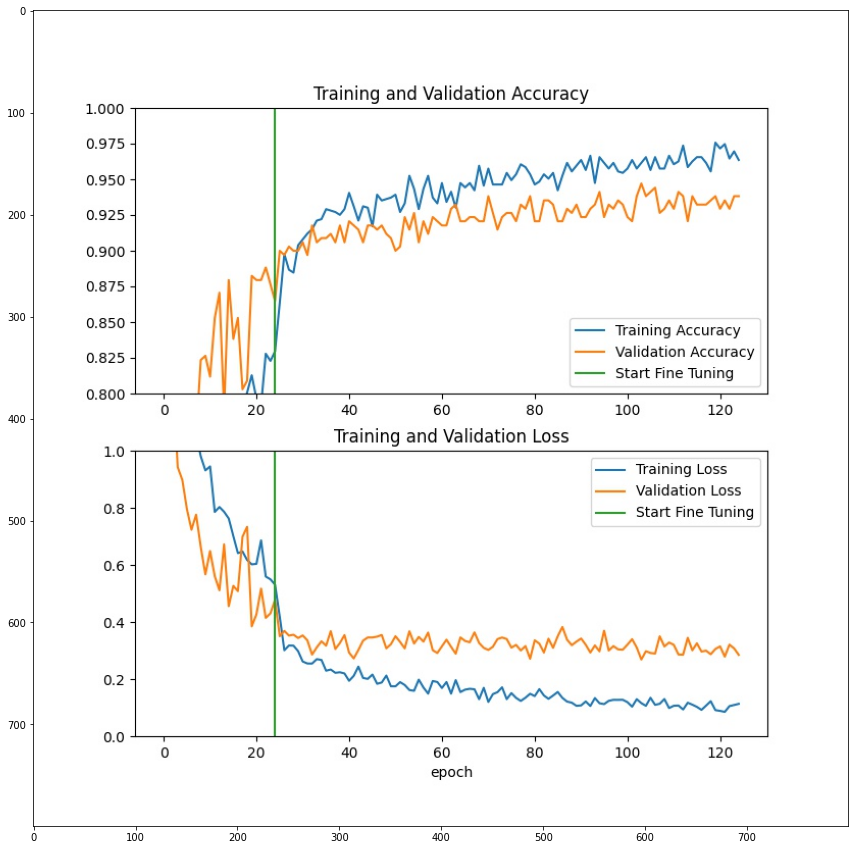

In [21]:
plt.figure(figsize=(15,15))
img = cv2.imread("output/fine_tuning.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Conclusion

As seen in the results, fine-tuning improves the accuracy. In the previous example, we've obtained $92\%$ of accuracy on the predictions. Here, the results show a certain gain. The inconvenient is the loss function curve, it shows a gap. The value of the validation loss is the double of the training loss. The graphic indicates a state of over-fit, even if we have good results on the predictions. In all case, transfer learning enable us to have a good classifiers.